In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

df = pd.read_csv('Uber Request Data (2).csv')
df.head()

,Request_id,Pickup_point,Driver_id,Status,Request_timestamp,Drop_timestamp
0,619,Airport,1.0,Trip Completed,11/7/2016 11:51,11/7/2016 13:00
1,867,Airport,1.0,Trip Completed,11/7/2016 17:57,11/7/2016 18:47
2,1807,City,1.0,Trip Completed,12/7/2016 9:17,12/7/2016 9:58
3,2532,Airport,1.0,Trip Completed,12/7/2016 21:08,12/7/2016 22:03
4,3112,City,1.0,Trip Completed,13/07/2016 08:33:16,13/07/2016 09:25:47


In [ ]:
data=df.copy()

#drop unnecessary columns
data=data.drop(['Request_id','Driver_id','Drop_timestamp'], axis=1)
data.head()

,Pickup_point,Status,Request_timestamp
0,Airport,Trip Completed,11/7/2016 11:51
1,Airport,Trip Completed,11/7/2016 17:57
2,City,Trip Completed,12/7/2016 9:17
3,Airport,Trip Completed,12/7/2016 21:08
4,City,Trip Completed,13/07/2016 08:33:16


In [ ]:
#checking unique values in status column
data['Status'].value_counts()

,count
Status,
Trip Completed,2831
No Cars Available,2650
Cancelled,1264


In [ ]:
#dividing the trips into 6 sessions based on dt.hour from Request Timestamp
session_labels=['Late Night','Early Morning','Late Morning','Afternoon','Evening','Night']

# Function to handle multiple datetime formats
def parse_datetime(value):
    formats = [
        "%d/%m/%Y %H:%M:%S",
        "%m-%d-%Y %H:%M",
        "%Y-%m-%d %H:%M:%S",
        "%m/%d/%Y %I:%M %p",
        "%Y-%m-%d",
        "%d-%m-%Y",
        "%m/%d/%Y %H:%M",   # For format like '11/7/2016 11:51'
        "%m/%d/%Y %I:%M %p" # For format like '7/11/2016 11:51 AM'
    ]
    for fmt in formats:
        try:
            return pd.to_datetime(value, format=fmt)
        except ValueError:
            continue
    return pd.NaT

# Apply the parsing function
data['parsed_req_datetime'] = data['Request_timestamp'].apply(parse_datetime)

# Check for NaT values
print("Rows with NaT values:")
print(data[data['parsed_req_datetime'].isna()])

# Create the 'session' column based on the hour of the 'parsed_req_datetime'
data['session'] = pd.cut(data['parsed_req_datetime'].dt.hour,
                            bins=[-1, 4, 8, 12, 16, 20, 24],
                            labels=session_labels)

# Display the first few rows
data.head()


Rows with NaT values:
Empty DataFrame
Columns: [Pickup_point, Status, Request_timestamp, parsed_req_datetime]
Index: []


,Pickup_point,Status,Request_timestamp,parsed_req_datetime,session
0,Airport,Trip Completed,11/7/2016 11:51,2016-11-07 11:51:00,Late Morning
1,Airport,Trip Completed,11/7/2016 17:57,2016-11-07 17:57:00,Evening
2,City,Trip Completed,12/7/2016 9:17,2016-12-07 09:17:00,Late Morning
3,Airport,Trip Completed,12/7/2016 21:08,2016-12-07 21:08:00,Night
4,City,Trip Completed,13/07/2016 08:33:16,2016-07-13 08:33:16,Early Morning


#### Session Details
- Late Night: Midnight to 4AM
- Early Morning: 4AM-8AM
- Late Morning: 8AM-Noon
- Afternoon: Noon-4PM
- Evening: 4PM-8PM
- Night: 8PM-Midnight

In [ ]:
data['session'].value_counts()

,count
session,
Evening,1893
Early Morning,1672
Late Morning,1029
Night,947
Afternoon,626
Late Night,578


<ipython-input-11-c3505512725a>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(['session','Status']).Status.count().unstack().plot.bar(legend=True, figsize=(15,10), color=colors)


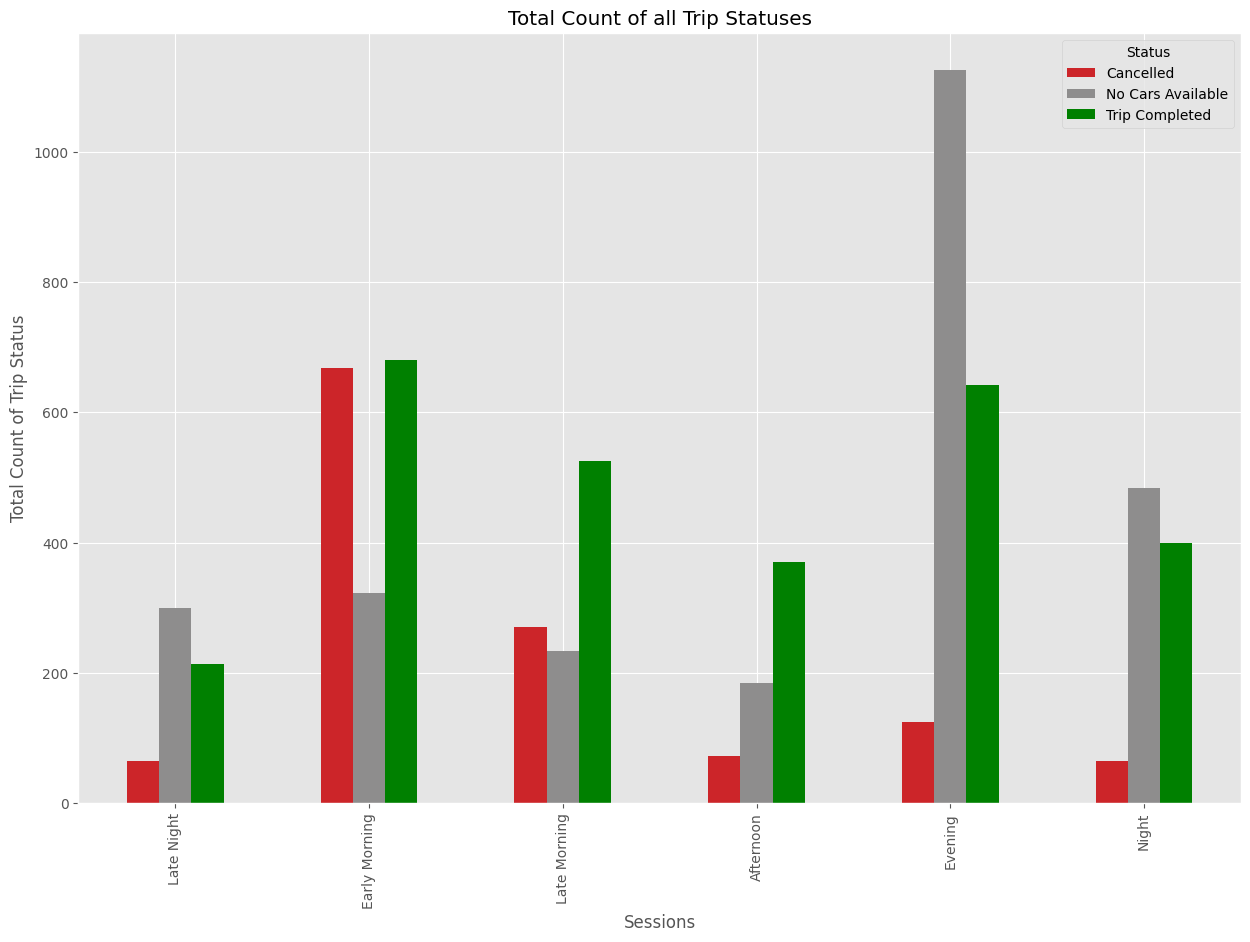

In [ ]:
# plotting share/frequency of all "Trip Status" over the day to identify problem areas
plt.style.use('ggplot')
colors = ["#CC2529", "#8E8D8D","#008000"]
data.groupby(['session','Status']).Status.count().unstack().plot.bar(legend=True, figsize=(15,10), color=colors)
plt.title('Total Count of all Trip Statuses')
plt.xlabel('Sessions')
plt.ylabel('Total Count of Trip Status')
plt.show()

### Observations:

#### 1. Maximum number of "No Cars Available" status trips can be seen in Evening Session (Time Slot: 4PM to 8PM), followed by Night session (8PM to Midnight).

#### 2. Maximum number of "Cancelled" status trips can be seen in Early Morning Session (Time Slot: 4AM to 8AM), followed by Late Morning session (8AM to Noon).


### Let's drill down further in each category to do a deeper analysis

In [ ]:
# Filtering out only "Cancelled"  trips
df_tripscancelled=data[data["Status"].str.contains('Cancelled')==True]
df_tripscancelled=df_tripscancelled.reset_index(drop=True)
df_tripscancelled.head()

,Pickup_point,Status,Request_timestamp,parsed_req_datetime,session
0,City,Cancelled,13/07/2016 06:08:41,2016-07-13 06:08:41,Early Morning
1,City,Cancelled,14/07/2016 17:07:58,2016-07-14 17:07:58,Evening
2,Airport,Cancelled,14/07/2016 20:51:37,2016-07-14 20:51:37,Evening
3,City,Cancelled,15/07/2016 10:12:40,2016-07-15 10:12:40,Late Morning
4,Airport,Cancelled,12/7/2016 19:14,2016-12-07 19:14:00,Evening


<ipython-input-13-487424b0ef08>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_tripscancelled.groupby(['session','Pickup_point']).Pickup_point.count().unstack().plot.bar(legend=True, figsize=(15,10), color=colors)


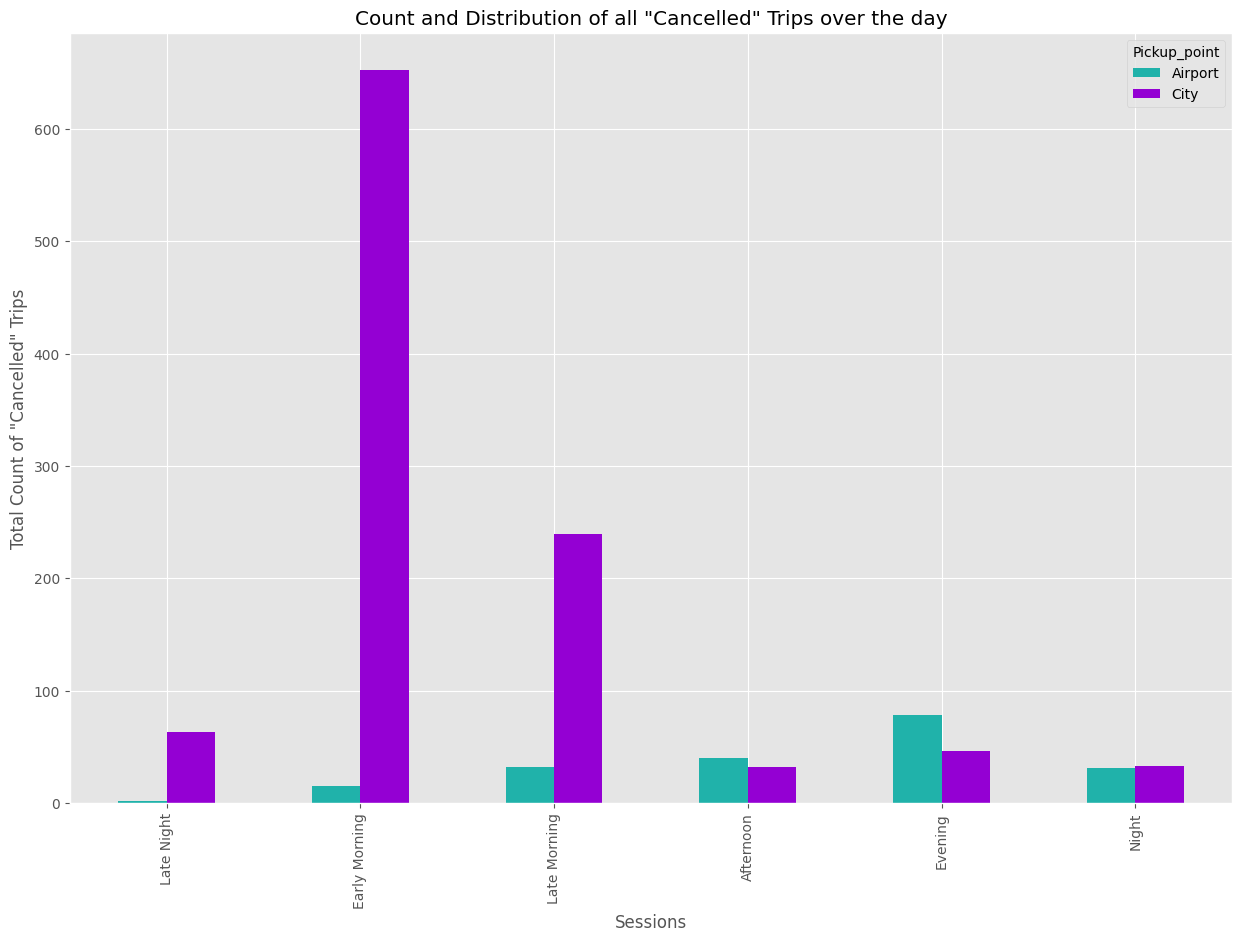

In [ ]:
# plotting share/frequency of all Cancelled trips over the day to identify problem areas
plt.style.use('ggplot')
colors = ["#20B2AA", "#9400D3"]
df_tripscancelled.groupby(['session','Pickup_point']).Pickup_point.count().unstack().plot.bar(legend=True, figsize=(15,10), color=colors)
plt.title('Count and Distribution of all "Cancelled" Trips over the day')
plt.xlabel('Sessions')
plt.ylabel('Total Count of "Cancelled" Trips')
plt.show()

### Observation
 1. Maximum Cancellations happen in "Early Morning" (4AM-8AM) session where the pick up is "City", followed by Late Morning session (8AM-Noon)

### Inference:
**Most number of cancellations** happen in the **Morning hours (4AM-8AM)** in the **City to Airport** route

In [ ]:
# Filtering out only "Cancelled"  trips
df_nocar=data[data["Status"].str.contains('No Car')==True]
df_nocar=df_nocar.reset_index(drop=True)
df_nocar.head()

,Pickup_point,Status,Request_timestamp,parsed_req_datetime,session
0,City,No Cars Available,11/7/2016 0:02,2016-11-07 00:02:00,Late Night
1,City,No Cars Available,11/7/2016 0:06,2016-11-07 00:06:00,Late Night
2,City,No Cars Available,11/7/2016 0:09,2016-11-07 00:09:00,Late Night
3,Airport,No Cars Available,11/7/2016 0:23,2016-11-07 00:23:00,Late Night
4,Airport,No Cars Available,11/7/2016 0:30,2016-11-07 00:30:00,Late Night


<ipython-input-16-5e14ff53202d>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_nocar.groupby(['session','Pickup_point']).Pickup_point.count().unstack().plot.bar(legend=True, figsize=(15,10), color=colors)


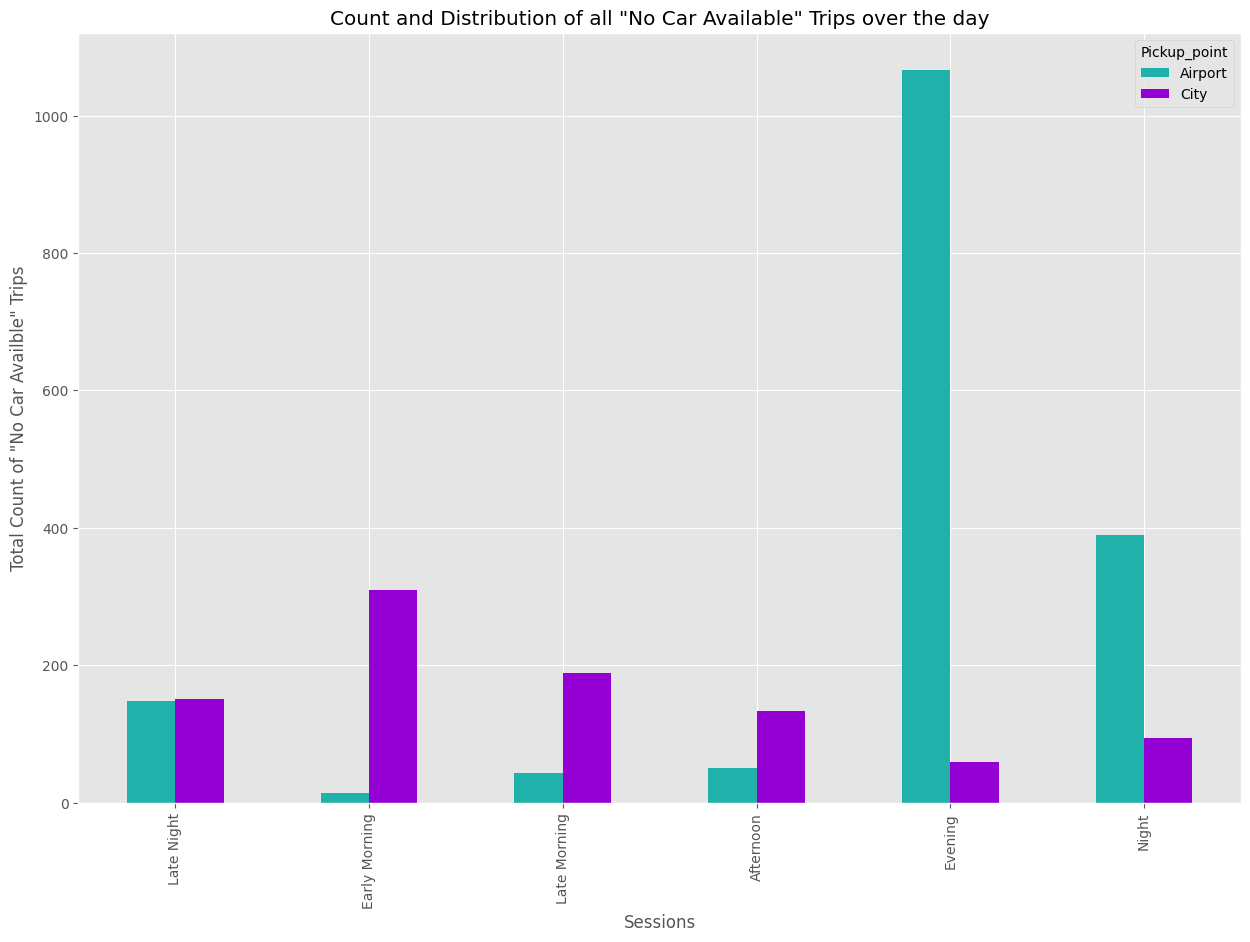

In [ ]:
plt.style.use('ggplot')
colors = ["#20B2AA", "#9400D3"]
df_nocar.groupby(['session','Pickup_point']).Pickup_point.count().unstack().plot.bar(legend=True, figsize=(15,10), color=colors)
plt.title('Count and Distribution of all "No Car Available" Trips over the day')
plt.xlabel('Sessions')
plt.ylabel('Total Count of "No Car Availble" Trips')
plt.show()


### Observation
 1. Maximum "No Cars Available" trips happen in "Evening" (4PM-8PM) session where the pick up is "Airport", followed by Night session (8PM-Midnight)

### Inference
Most number of **No Cars Available**  happen in the **Evening Hours (4PM-8PM)** in the **Airport to City** route

### Let's drill down further by Pick-Up Point

<ipython-input-17-9212bf591a36>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_citytoairport.groupby(['session','Status']).Status.count().unstack().plot.bar(legend=True, figsize=(15,10), color=colors)


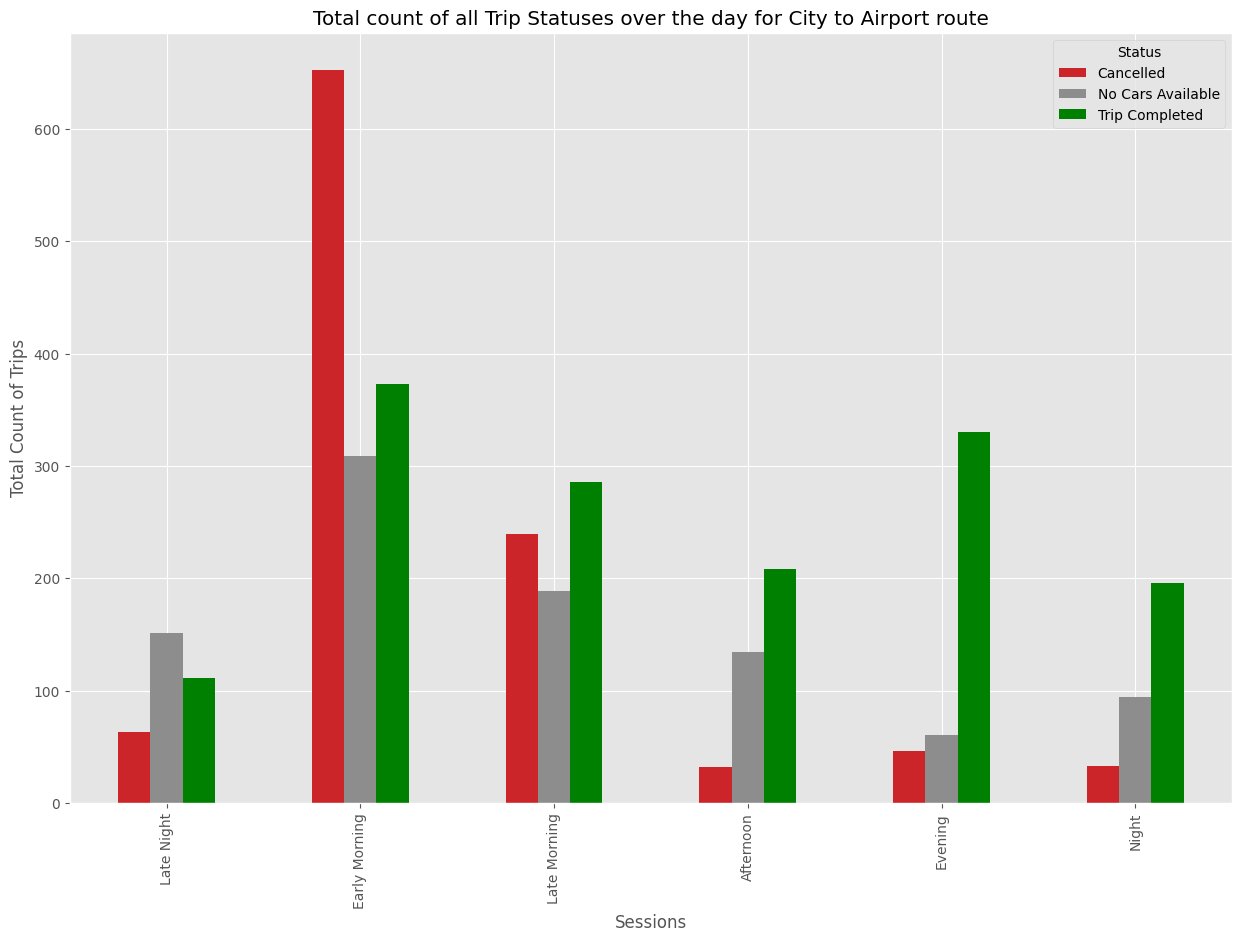

In [ ]:
# Filtering out trips in the City to Airport route. Pick-up Point - City
df_citytoairport=data[data["Pickup_point"].str.contains('City')==True]
plt.style.use('ggplot')
colors = ["#CC2529", "#8E8D8D","#008000"]
df_citytoairport.groupby(['session','Status']).Status.count().unstack().plot.bar(legend=True, figsize=(15,10), color=colors)
plt.title('Total count of all Trip Statuses over the day for City to Airport route')
plt.xlabel('Sessions')
plt.ylabel('Total Count of Trips')
plt.show()

### We see that maximum trips are cancelled from City to airport in the Early Morning session followed by Late Morning Session

<ipython-input-18-016c48ac9f79>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_airporttocity.groupby(['session','Status']).Status.count().unstack().plot.bar(legend=True, figsize=(15,10), color=colors)


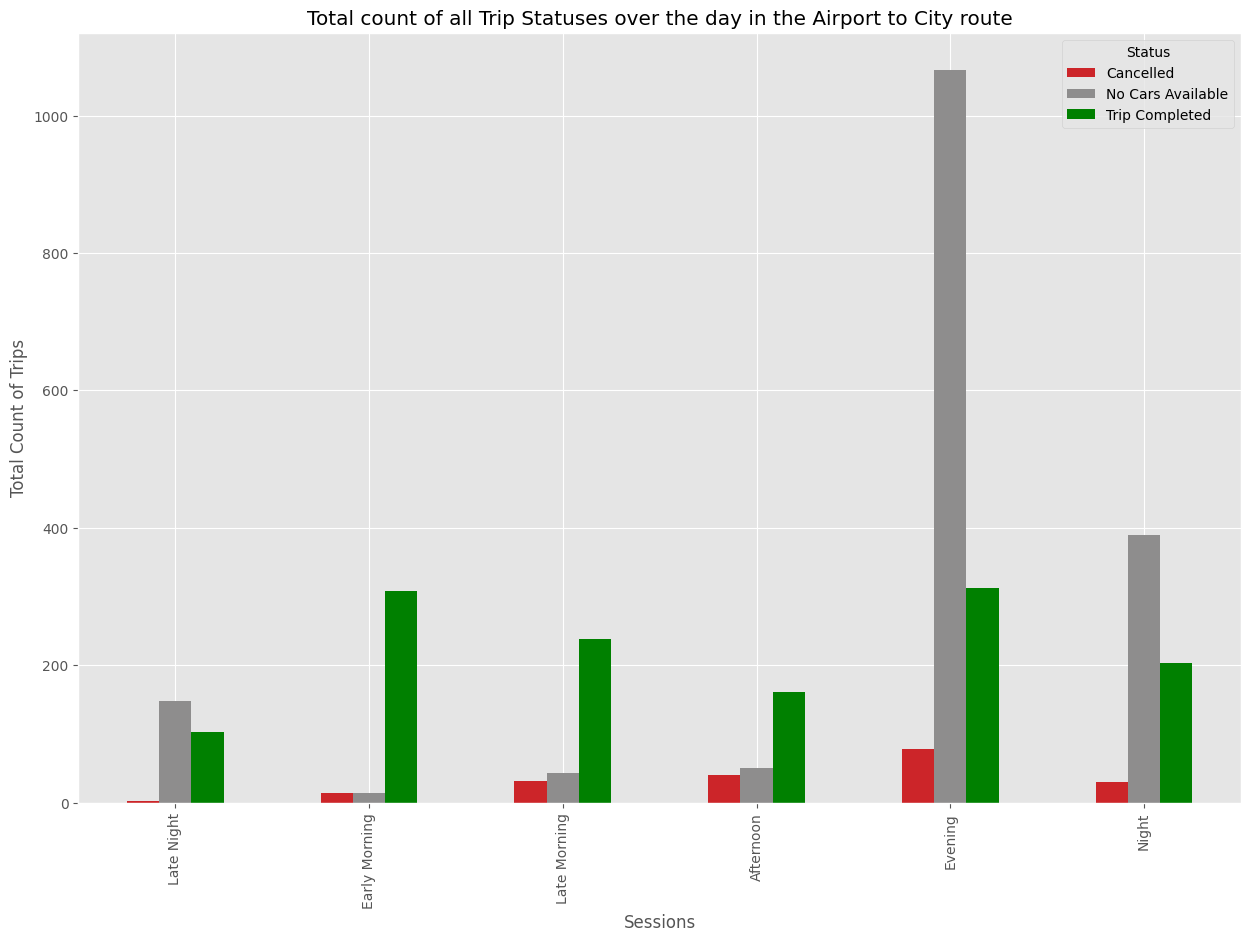

In [ ]:
# Filtering out trips in the Airport to route. Pick-up Point - Airport
df_airporttocity=data[data["Pickup_point"].str.contains('Airport')==True]
plt.style.use('ggplot')
colors = ["#CC2529", "#8E8D8D","#008000"]
df_airporttocity.groupby(['session','Status']).Status.count().unstack().plot.bar(legend=True, figsize=(15,10), color=colors)
plt.title('Total count of all Trip Statuses over the day in the Airport to City route')
plt.xlabel('Sessions')
plt.ylabel('Total Count of Trips')
plt.show()

### We see that maximum number of "No Cars Available" from Airport to city in the Evening session followed by Night Session

Lets Try to understand the **Supply** and **Demand** curve by considering all **Trips Completed** as **Supply** and **Cancelled** and **No Cars Available** as **Demand**

In [ ]:
data['supply_demand'] = ['Supply' if x == 'Trip Completed' else 'Demand' for x in data['Status']]
data.head()

,Pickup_point,Status,Request_timestamp,parsed_req_datetime,session,supply_demand
0,Airport,Trip Completed,11/7/2016 11:51,2016-11-07 11:51:00,Late Morning,Supply
1,Airport,Trip Completed,11/7/2016 17:57,2016-11-07 17:57:00,Evening,Supply
2,City,Trip Completed,12/7/2016 9:17,2016-12-07 09:17:00,Late Morning,Supply
3,Airport,Trip Completed,12/7/2016 21:08,2016-12-07 21:08:00,Night,Supply
4,City,Trip Completed,13/07/2016 08:33:16,2016-07-13 08:33:16,Early Morning,Supply


<ipython-input-21-b669d86d9c3c>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_citytoairport_supplydemand.groupby(['session','supply_demand']).supply_demand.count().unstack().plot.line(legend=True, figsize=(15,10))


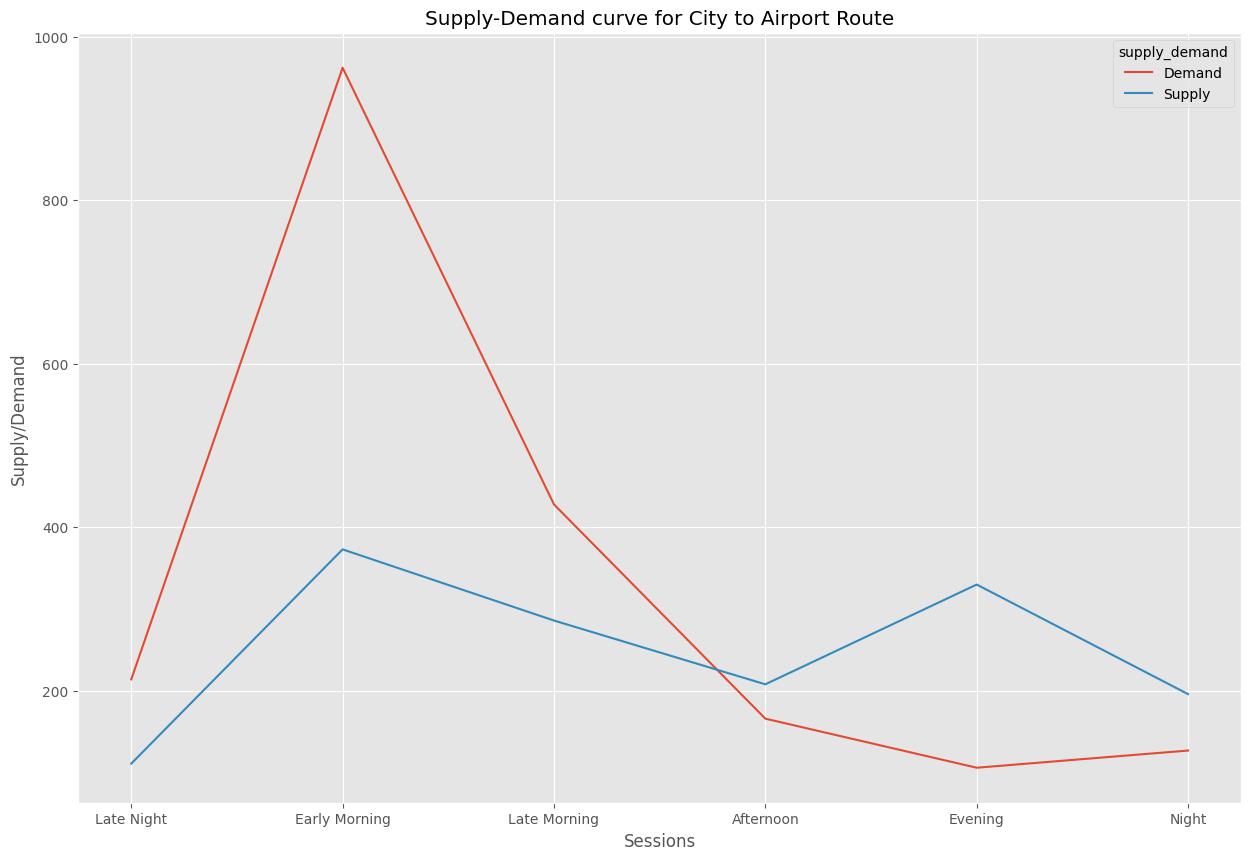

In [ ]:
#Plotting Supply and Demand on the City to Airport Route
df_citytoairport_supplydemand=data[data["Pickup_point"].str.contains('City')==True]
plt.style.use('ggplot')
df_citytoairport_supplydemand.groupby(['session','supply_demand']).supply_demand.count().unstack().plot.line(legend=True, figsize=(15,10))
plt.title('Supply-Demand curve for City to Airport Route')
plt.xlabel('Sessions')
plt.ylabel('Supply/Demand')
plt.show()

We observe that the **Demand is very high in the morning from City to Airport route but the supply is very low**

<ipython-input-23-b44ab90df84d>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_airporttocity_supplydemand.groupby(['session','supply_demand']).supply_demand.count().unstack().plot.line(legend=True, figsize=(15,10))


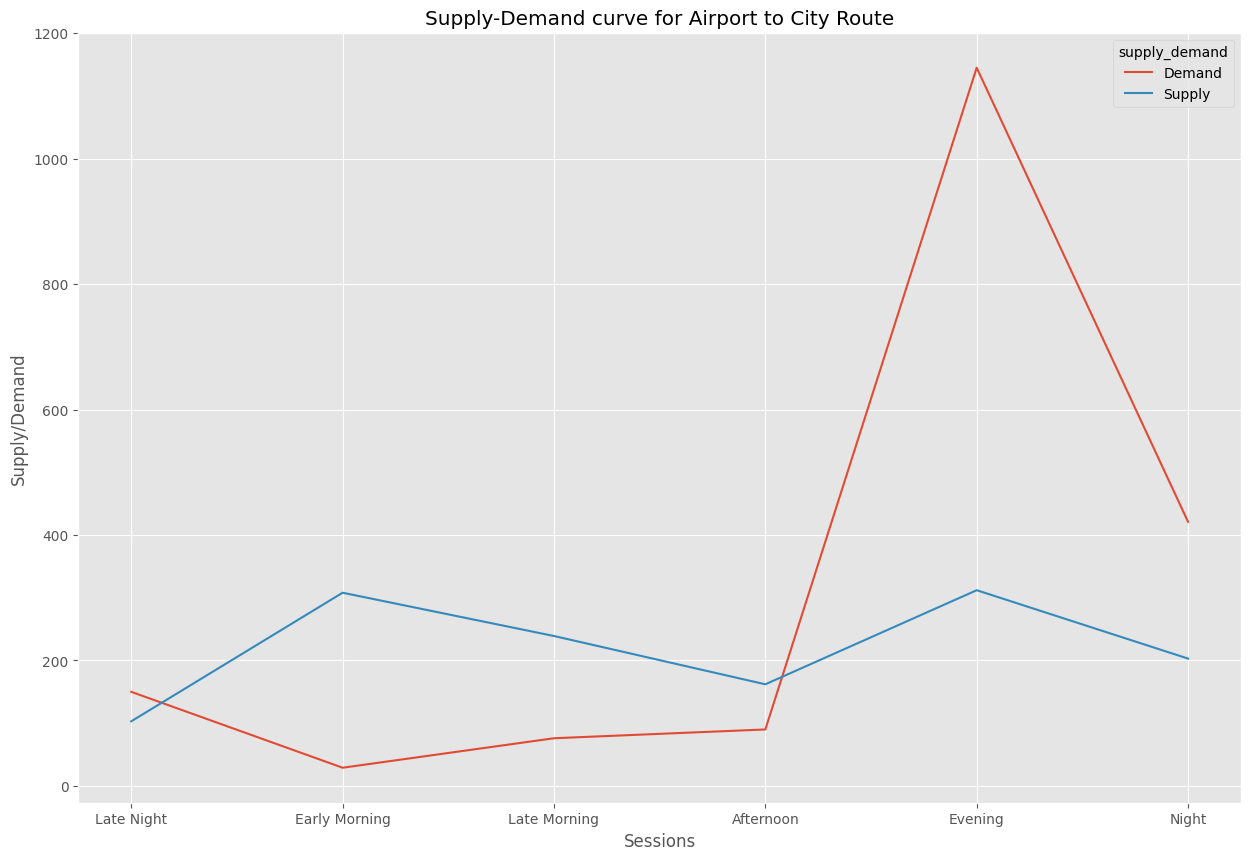

In [ ]:
#Plotting Supply and Demand on the Airport to City route
df_airporttocity_supplydemand=data[data["Pickup_point"].str.contains('Airport')==True]
plt.style.use('ggplot')
df_airporttocity_supplydemand.groupby(['session','supply_demand']).supply_demand.count().unstack().plot.line(legend=True, figsize=(15,10))
plt.title('Supply-Demand curve for Airport to City Route')
plt.xlabel('Sessions')
plt.ylabel('Supply/Demand')
plt.show()

We observe that the **Demand is very high in the evening in the Airport to City route but the supply is very low**

#### Correlating these two plots, a possible hypothesis could be:
1. The demand during morning and afternoon hours from the Airport to City is quite low, which means that a driver who completed a City to Airport route in the morning hours may have to wait a really long time to get a ride back to the City, or he may have to come back without a passenger. Both situations are not idle for drivers, which might be the reason for highest number of "Cancelled" trips in the City to Airport trip in the morning hours

2. The vice versa happens in evening when there are too many flight coming in to the airport and hence there is a high demand for cabs and not enough supply. which is why most number of "No Cars Available" were observed in Evening in the Airport to City route.

#### Possible Solution:

1. Give incentives/surge pricing/bonus for trips from City to Airport during Morning hours.
2. Give incentives/surge pricing/bonus for trips from Airport to City during Evening hours.
3. Uber can give Gas expense to drivers qwhen they return from Airport without a ride or go to airpot for pick up without a ride.
4. Uber can increase market share by marketing campaigns and offers to customers when demand is low.